# Semiconductor Bloch Equations with Coulomb Interaction

## Abstract

This python module **SBEwithCI.py** is developed for simulating exciton effect on optical response in solid with Semiconductor Bloch Equations (SBEs). 

## Quick Start

run test.py

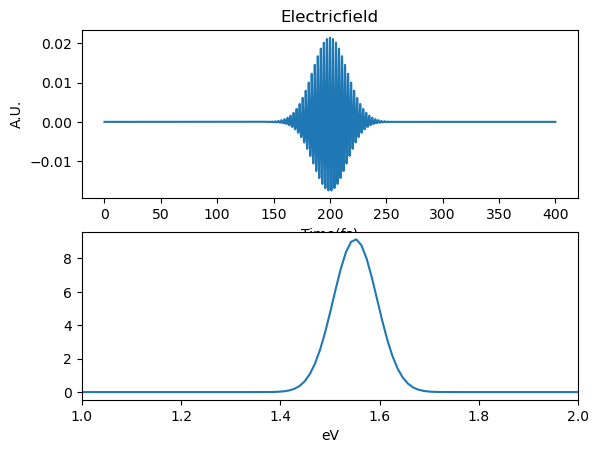

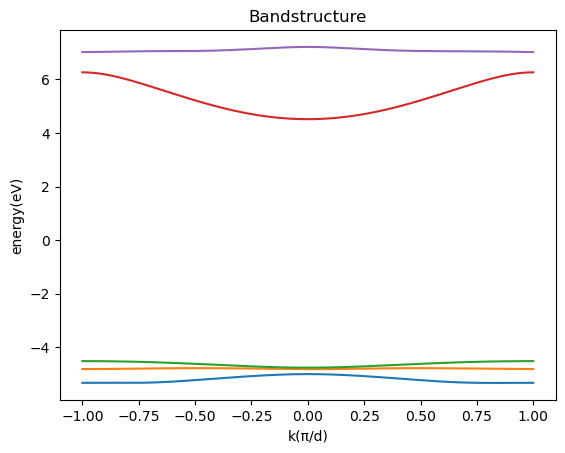

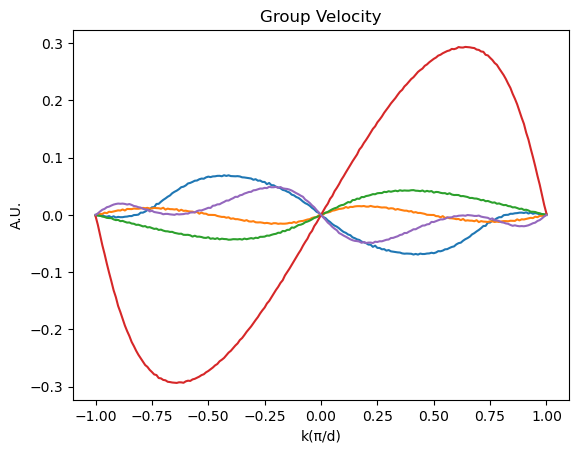

C:\Users\Wenqi\anaconda3\lib\site-packages\numpy\ma\core.py:2829: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


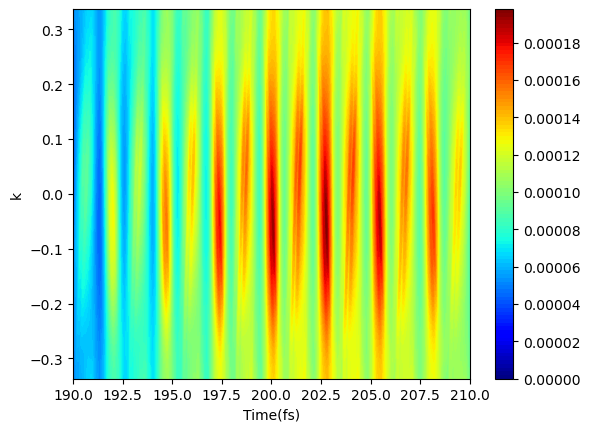

C:\Users\Wenqi\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


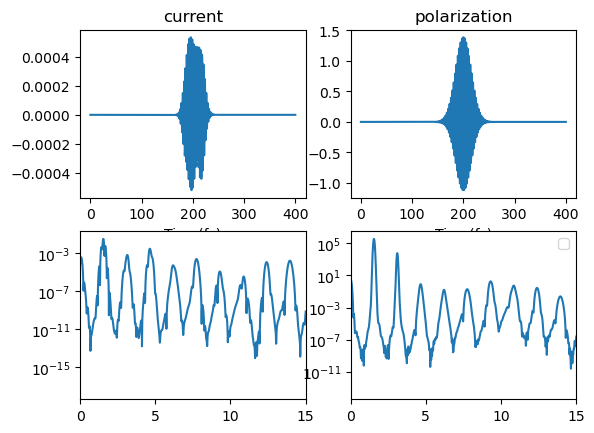

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import sqrt
from SBEwithCI import SBE, loadband, Matplot
import time as tp
import copy
from multiprocessing import Pool
import multiprocessing as mp
from matplotlib import cm

from numpy.fft import fft, fftfreq,fftshift,ifft

#all the value should be convert to atomic unit

if __name__ == '__main__': #similar to main function in C/C++, multiprocessing need this

    
    pi=scipy.constants.pi #pi constant
    d=9.32                  #lattice constant
    t=np.linspace(0,41*400,10000) #time axis
    k=np.linspace(-pi/d, pi/d,201)    #k axis
    dk=k[1]-k[0]
    
    
    #set electric field 0
    w1=0.057       #frequency
    tau=41*25*sqrt(2) #pulse duration
    fi=0               #phase
    E0=1e10             #field strength
    E0field=np.exp(-4*np.log(2)*((t-41*200)/tau)**2)*np.cos(w1*(t-41*200)+fi)/5.14e11*E0  #field 0
    
    #set electric field 1 (optional)
    w2=0.057*2         #frequency
    tau1=41*30*sqrt(2) #pulse duration
    fi1=0             #phase
    E1=1e9         #field strength
    delay=0          #delay between two pulses
    E1field=np.exp(-4*np.log(2)*((t-41*200-delay)/tau1)**2)*np.cos(w2*(t-41*200-delay)+fi1)/5.14e11*E1 #field 1
    
    #load band structure

    Ek=np.loadtxt('jicai_project/bandstructure5.txt')
    Ek=np.hstack((np.flip(Ek[:,1:],axis=1),Ek))/27.21 #symmetry band structure
    
      
    VB=np.array(Ek[0:3])#assign VB
    CB=np.array(Ek[3:])#assign CB
    
    
    
    
    
    #set mapping matrix
    MP=np.linspace(0,len(Ek)**2-1,len(Ek)**2,dtype=int).reshape((len(Ek),len(Ek)))
    
    #set transition dipole matrix
    
    dipole=np.array([np.zeros(k.size) for i in range(len(Ek)**2)])     #dipole should be a n^2 by k matrix ,n is the number of energy bands
   
    #K-p theory
    for p in range(len(Ek)):
        for q in range(len(Ek)):
            if p==q:
                pass
            else:
                if p<=2 and q<=2: #use condition to set different value of dipole for each band
                    dipole[MP[p,q]]=0.1*(Ek[p,100]-Ek[q,100])/(Ek[p]-Ek[q])
                else:
                    dipole[MP[p,q]]=0.1*(Ek[p,100]-Ek[q,100])/(Ek[p]-Ek[q])
    
    
    
    
    
    
    
    
    #set dephasing time
    T2=41*2
    #relaxation time
    T1=41*5
    
    #set coulomb potential(FFT of 1D soft Coulomb)
    Vkq=np.ones((k.size,k.size))*(0+0j)
    V0=0.1
    for p in range(k.size):
        Vkq[p]=V0*dk/2/pi*2*scipy.special.kn(0,np.abs(k[p]-k))   #kn is modified Bessel function of the second kind
    Vkq[np.diag_indices_from(Vkq)]=0+0j
    
    
    #set filter for FFT when calculating Pw and Jw
    gauss=np.exp(-4*np.log(2)*((t-41*200)/180/41)**12)     

    SBEg=SBE(d,VB,CB,dipole,k,E0field,E1field,T2,T1,t,Vkq)  #create a SBE object
    SBEg.solve()                                                #solve the PDE 
    SBEg.calculate(gauss)                                       #calculate the P(t),J(t),d(t),P(ω)，J(ω),d(ω), and absorption spectrum
    SBEg.showEfield(rangex=(1,2))                            #plot the electric field in time and frequency, rangex is the range of energy (eV)
    SBEg.showEnergy()                                           #plot all the energy bands
    SBEg.plotelectrondensity(n=0,rangex=(190,210))                  #plot the electron/hole density dynamics on n-th band, rangex is the range of tiem (fs)
    SBEg.plotemission(rangex=(0,15))                           #plot P(t),J(t),P(ω)，J(ω),rangex is the range of energy (eV)
 


## Parameters Input

IMPORTANT NOTE: When you create a new array in numpy, it is a row vector.

### Load Band Structure

In the **SBEwithCI** module, the **loadband** function is provided to help you load the bandstructure from txt file. The txt file should have 2 column, first column is the k points and second one is the value of energy. The 

In [1]:
def loadband(k,filename):                                  
    band=np.loadtxt(filename).T                            #load txt data
    band[1]=savgol_filter(band[1],11,1)                    #smooth data
    f=interpolate.interp1d(band[0],band[1])                #Interpolation for your setting k grid
    newband=f(k)
    return newband

CB1=loadband(k,'bandstructure\\CB1.txt')                    #It will load the CB1 from your CB1.txt for your setting grid

After you load all the energy band respectively, you should put them in Valence/Conduct band matrix. I recommend to put them in order of energy. Then create a matrix include all the energy bands.

In [ ]:
VB=np.array([VB1,VB2,VB3,......])
CB=np.array([CB1,CB2,CB3,......])
Ek=np.vstack((VB,CB))

### Transition Dipole Matrix Element

The TDM should have n*n rows and k-points columns.
And the rule for the sequence is shown in following table. 

Suppose that the system only have 3 energy bands.

| Row in TDM | Assignment |
|:-:|:-:|
|Row1|Dipole for 1st band to 1st band|
|Row2|Dipole for 1st band to 2nd band|
|Row3|Dipole for 1st band to 3rd band|
|Row4|Dipole for 2nd band to 1st band|
|Row5|Dipole for 2nd band to 2nd band|
|Row6|Dipole for 2nd band to 3rd band|
|Row7|Dipole for 3rd band to 1st band|
|Row8|Dipole for 3rd band to 2nd band|
|Row9|Dipole for 3rd band to 3rd band|



You can also use the Mapping Matrix to set the dipole. `Mapping(0,1)` is exactly equal to 1, so that `dipole[Mapping(0,1)]` represent the Row2 of TDM, here the `0` and `1` represent the first and second band.

### Coulomb Potential

Here we employ the Coulomb interaction as 
$$V_{k,k^{'}}=V_{0}\frac{dk}{2\pi}2K_{0}(|k-k^{'}|)$$
where $V_0$ is the strength of the electron-hole interaction, and $K_0$ is the
modified Bessel function of the second kind.

The coulomb matrix could be created by a simple loop.

In [ ]:
Vkq=np.ones((k.size,k.size))*(0+0j)
V0=1.8
for p in range(k.size):
    Vkq[p]=V0*dk/2/pi*2*scipy.special.kn(0,np.abs(k[p]-k))    
Vkq[np.diag_indices_from(Vkq)]=0+0j

## SBE class

SBEg=SBE(d,VB,CB,dipole,k,E0field,E1field,T2,T1,t,Vkq)

As shown in above the SBE object have 11 parameters. And their form is shown in the following Table.

|Parameters|Form|
|:-:|:-:|
|lattice constant:d|constant|
|Valence Band:VB|N1 by k matrix|
|Conduct Band:CB|N2 by k matrix|
|Transition Dipole Moment:Dipole|(N1+N2)^2 by k matrix|
|k-points:k| 1 by k matrix|
|Electic field 0:E0field| 1 by t matrix|
|Electic field 1:E1field| 1 by t matrix|
|Coherence Dephasing Time:T2| constant|
|Relaxation Time:T1| constant|
|time:t|1 by t matrix|
|Coulomb Potential:Vkq| k by k matrix|

### Properties

Besides the above parameters, the SBE class also have many properties which are shown in following table.

|Variable name|Meaning|
|:-:|:-:|
|Vg|Group Velocity of all the energy bands|
|Efield|Totol electric field|
|freqs|fft of time|
|energy|freqs * 2π * 27.21 (eV)|
|Pt|Polarization|
|Pw|fft of Pt|
|SwP| \|Pw\|^2||
|Jt|Current|
|Jw|fft of Jt|
|SwJ| \|Jw\|^2|
|absorption| absorption spectrum|

All the properties can be call by 

`SBEg=SBE(d,VB,CB,dipole,k,E0field,E1field,T2,T1,t,Vkq)`\
`SBEg.xxxx  (xxxx=properties' name)`

### Solving the PDE

After create a new SBE object, one should use `SBEg.solve()` to solve the PDE.

In [1]:
    def solve(self):
        self.calculateddt()                            #calculate energy difference and dephasing term
        self.hindex=np.linspace(0, self.fhN-1,self.fhN,dtype=int)                         #set hole/valence band index
        self.eindex=np.linspace(self.fhN, self.feN+self.fhN-1,self.feN,dtype=int)         #set electron/conduct band index
        self.parameter1=(self.bandN,self.kN,self.T1,self.dk)                              #put all the constant parameter in a tuple
        self.parameter2=(self.time,self.Efield,self.dipole,self.ddt,self.MP,self.Vkq,self.k,self.hindex,self.eindex) #put all the array constant in a tuple
        self.sol=solve_ivp(finiteSBE, (self.time[0],self.time[-1]),self.y0, t_eval=self.time,atol=1e-10,rtol=1e-12,args=(self.parameter1,self.parameter2) #use solve_ivp to solve the PDE, change the atol and rtol to control the accuracy

SyntaxError: unexpected EOF while parsing (225012329.py, line 7)

The details of the SBE PDE is in `finiteSBE.py`, and it use the `numba.njit` to compile the derivative equations function to machine code.  

### Calculating the result

After solve the PDE, you should use `SBEg.calculate(filter)` to calculate the P(t),J(t),d(t),P(ω)，J(ω),d(ω), and absorption spectrum.


In [ ]:
    def calculate(self,Filter):
        y=self.sol.y.T                                            
        self.Pt=np.zeros(self.sol.t.size,dtype=complex)
        self.Jt=np.zeros(self.sol.t.size,dtype=complex)
        self.fkt=np.zeros((self.sol.t.size,self.bandN*self.kN),dtype=complex)
        self.pkt=np.zeros((self.sol.t.size,self.bandN**2*self.kN),dtype=complex)
        for i in range(len(self.sol.t)):
            yi=np.reshape(y[i],(self.bandN**2+self.bandN,self.kN))
            pk=yi[0:self.bandN**2]
            fk=yi[self.bandN**2:]
            self.Pt[i]=np.real(np.sum(np.sum(self.dipole*pk,1)))
            #self.Pt[i]=np.sum(np.sum(self.dipole*pk,1))
            self.Jt[i]=np.real(np.sum(np.sum(self.Vg*fk,1)))
            #self.Jt[i]=np.sum(np.sum(self.Vg*fk,1))
            self.pkt[i]=pk.reshape(pk.size)
            self.fkt[i]=fk.reshape(fk.size)
        self.Pw=fftshift((fft(self.Pt*Filter)))
        self.Jw=fftshift((fft(self.Jt*Filter)))
        self.SwP=np.abs(self.Pw)**2
        self.SwJ=np.abs(self.Jw)**2
        self.dt=difft(self.Pt,self.time)+self.Jt
        self.dw=fftshift((fft(self.dt*Filter)))
        self.Sw=np.abs(self.dw)**2
        self.Ew=fftshift(fft(self.E0))
        self.absorption=self.freqs*np.imag(self.Pw/self.Ew)

### Plot the result

The SBE class provide several method to help you plot your result.

In [ ]:
    def showEfield(self,rangex): #plot the electric field
        plt.figure(1)
        plt.subplot(2,1,1)
        plt.plot(self.time/41,self.Efield)
        plt.title('Electricfield')
        plt.ylabel('A.U.')
        plt.xlabel('Time(fs)')
        plt.subplot(2,1,2)
        plt.plot(self.freqs*2*pi*27.21,np.abs(fftshift(fft(self.Efield))))
        plt.xlabel('eV')
        plt.xlim(rangex[0],rangex[1])
        plt.show()

In [ ]:
    def showEnergy(self): #plot the bandstructure
        plt.figure()
        Matplot(self.Ek*27.21,self.k/pi*self.d)
        plt.title('Bandstructure')
        plt.xlabel('k(π/d)')
        plt.ylabel('energy(eV)')
        plt.figure()
        Matplot(self.Vg,self.k/pi*self.d)
        plt.title('Group Velocity')
        plt.ylabel('A.U.')
        plt.xlabel('k(π/d)')
        plt.show()

In [ ]:
    def plotelectrondensity(self,n,rangex):  #plot electronsity on n-th band with time range
        plt.figure(2)
        self.fkn=(self.fkt.T)[n*self.kN:(n+1)*self.kN]
        T,K=np.meshgrid(self.time,self.k)
        plt.contourf(T/41,K,self.fkn,cmap=cm.jet,levels=2**7);
        plt.ylabel('k')
        plt.xlabel('Time(fs)')
        plt.xlim(rangex[0],rangex[1])
        plt.colorbar()
        plt.show()

In [ ]:
    def plotcoherence(self,n,rangex):
        plt.figure(3)
        self.pkn=(self.pkt.T)[n*self.kN:(n+1)*self.kN]
        T,K=np.meshgrid(self.time,self.k)
        plt.contourf(T/41,K,self.pkn,cmap=cm.jet,levels=2**7);
        plt.ylabel('k')
        plt.xlabel('Time(fs)')
        plt.xlim(rangex[0],rangex[1])
        plt.colorbar()
        plt.show() 

In [ ]:
    def plotemission(self,rangex):#plot Pt,Jt,SwP,SwJ
        plt.figure(3)
        plt.subplot(2,2,1)
        plt.plot(self.sol.t/41,self.Jt)
        plt.title("current")
        plt.xlabel("Time(fs)")
        plt.subplot(2,2,2)
        plt.plot(self.sol.t/41,self.Pt)
        plt.title("polarization")
        plt.xlabel("Time(fs)")
        plt.subplot(2,2,3)
        plt.semilogy(self.energy,self.SwJ)
        plt.xlim(rangex[0],rangex[1])
        plt.subplot(2,2,4)
        plt.semilogy(self.energy,self.SwP)
        plt.xlim(rangex[0],rangex[1])
        plt.legend()
        plt.show()

In [ ]:
    def plotabsorption(self,rangex,rangey):#plot absorption of probe with x-range and y-range
        plt.figure(4)
        plt.plot(self.freqs*2*pi*27.21,self.absorption)
        plt.xlim(rangex[0],rangex[1])
        plt.ylim(rangey[0],rangey[1])
        plt.show()

## Parameters Scan

Here I provide a example for parameter scan.

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 18 12:40:42 2023

@author: Wenqi
"""


import numpy as np
import scipy
from matplotlib import pyplot as plt
from math import sqrt
from SBEwithCI import SBE, loadband, Matplot
import time as tp
import copy
from multiprocessing import Pool
import multiprocessing as mp
from matplotlib import cm

from numpy.fft import fft, fftfreq,fftshift,ifft


#A simple SBE simulation should be done before start the scan
def pumpprobe(SBEg,delay,pumpI,probeI,V0,T2,T1): #funcition of scan the parameter (delay,intensity of pump, intensity of probe, Coulomb potential strength, T2, T1)
    

    t=SBEg.time
    gauss=np.exp(-4*np.log(2)*((t-41*200)/180/41)**12)   
    w1=0.057       #frequency
    tau=41*25*sqrt(2) #pulse duration
    fi=0               #phase
    E0=1e9*pumpI             #field strength, pumpI is the intensity factor
    E0field=np.exp(-4*np.log(2)*((t-41*200)/tau)**2)*np.cos(w1*(t-41*200)+fi)/5.14e11*E0  #field 0
    
    #set electric field 1 (optional)
    w2=0.057*2         #frequency
    tau1=41*30*sqrt(2) #pulse duration
    fi1=0             #phase
    E1=1e9*probeI    #field strength, probeI is the intensity factor
    E1field=np.exp(-4*np.log(2)*((t-41*200-delay)/tau1)**2)*np.cos(w2*(t-41*200-delay)+fi1)/5.14e11*E1 #field 1
    
    SBE1=copy.deepcopy(SBEg)
    
    SBE1.T2=T2
    SBE1.T1=T1
    SBE1.Vkq=V0*SBE1.Vkq #Coulomb matrix, V0 is the strength factor
    SBE1.E0=E0field
    SBE1.Efield=E0field+E1field#new Efield
    SBE1.solve()#solve PDEs
    SBE1.calculate(gauss)#calculate the P(t),J(t),d(t),P(ω)，J(ω),d(ω), and absorption spectrum
    return SBE1.SwP     #also can return like (SBE1.SwP,SBE1.SwJ,SBE1.Sw)


if __name__ == '__main__': #similar to main function in C/C++, multiprocessing need this

    
    pi=scipy.constants.pi #pi constant
    d=9.32                  #lattice constant
    t=np.linspace(0,41*400,10000) #time axis
    k=np.linspace(-pi/d, pi/d,201)    #k axis
    dk=k[1]-k[0]
    
    
    #set electric field 0
    w1=0.057       #frequency
    tau=41*25*sqrt(2) #pulse duration
    fi=0               #phase
    E0=1e10             #field strength
    E0field=np.exp(-4*np.log(2)*((t-41*200)/tau)**2)*np.cos(w1*(t-41*200)+fi)/5.14e11*E0  #field 0
    
    #set electric field 1 (optional)
    w2=0.057*2         #frequency
    tau1=41*30*sqrt(2) #pulse duration
    fi1=0             #phase
    E1=1e9         #field strength
    delay=0          #delay between two pulses
    E1field=np.exp(-4*np.log(2)*((t-41*200-delay)/tau1)**2)*np.cos(w2*(t-41*200-delay)+fi1)/5.14e11*E1 #field 1
    
    #load band structure

    Ek=np.loadtxt('jicai_project/bandstructure5.txt')
    Ek=np.hstack((np.flip(Ek[:,1:],axis=1),Ek))/27.21 #symmetry band structure
    
      
    VB=np.array(Ek[0:3])#assign VB
    CB=np.array(Ek[3:])#assign CB
    
    
    
    
    
    #set mapping matrix
    MP=np.linspace(0,len(Ek)**2-1,len(Ek)**2,dtype=int).reshape((len(Ek),len(Ek)))
    
    #set transition dipole matrix
    
    dipole=np.array([np.zeros(k.size) for i in range(len(Ek)**2)])     #dipole should be a n^2 by k matrix ,n is the number of energy bands
   
    #K-p theory
    for p in range(len(Ek)):
        for q in range(len(Ek)):
            if p==q:
                pass
            else:
                if p<=2 and q<=2: #use condition to set different value of dipole for each band
                    dipole[MP[p,q]]=0.1*(Ek[p,100]-Ek[q,100])/(Ek[p]-Ek[q])
                else:
                    dipole[MP[p,q]]=0.1*(Ek[p,100]-Ek[q,100])/(Ek[p]-Ek[q])
    
    
    
    
    
    
    
    
    #set dephasing time
    T2=41*2
    #relaxation time
    T1=41*5
    
    #set coulomb potential(FFT of 1D soft Coulomb)
    Vkq=np.ones((k.size,k.size))*(0+0j)
    V0=0.1
    for p in range(k.size):
        Vkq[p]=V0*dk/2/pi*2*scipy.special.kn(0,np.abs(k[p]-k))   #kn is modified Bessel function of the second kind
    Vkq[np.diag_indices_from(Vkq)]=0+0j
    
    
    #set filter for FFT when calculating Pw and Jw
    gauss=np.exp(-4*np.log(2)*((t-41*200)/180/41)**12)     

    SBEg=SBE(d,VB,CB,dipole,k,E0field,E1field,T2,T1,t,Vkq)  #create a SBE object
    SBEg.solve()                                                #solve the PDE 
    SBEg.calculate(gauss)                                       #calculate the P(t),J(t),d(t),P(ω)，J(ω),d(ω), and absorption spectrum
    SBEg.showEfield(rangex=(1,2))                            #plot the electric field in time and frequency, rangex is the range of energy (eV)
    SBEg.showEnergy()                                           #plot all the energy bands
    SBEg.plotelectrondensity(n=0,rangex=(190,210))                  #plot the electron/hole density dynamics on n-th band, rangex is the range of tiem (fs)
    SBEg.plotemission(rangex=(0,15))                           #plot P(t),J(t),P(ω)，J(ω),rangex is the range of energy (eV)
 

    delaytime=np.linspace(-80,80,41)*41 #set delay time points
    V0=[0,7]                      #set Coulomb strength scan
    pumpI=[1,2,3,4,5,6,7,8,9,10]  #set pump intensity factor scan
    probeI=[3,4,5,6,7,8]        #set probe intensity factor scan
    T2scan=np.array([2])*41     #set T2 scan
    T1scan=np.array([2,5])*41   #set T1 scan
    
    scan=[(SBEg,tpoints,pumpIpoints,probeIpoints,V0points,T2points,T1points) for T1points in T1scan for T2points in T2scan for V0points in V0 for probeIpoints in probeI for pumpIpoints in pumpI for tpoints in delaytime ]
    for i in range(len(V0)*len(pumpI)*len(probeI)*len(T2scan)*len(T1scan)): #do delay scan loop for other parameters setting
        pool=Pool(4) #4 processing
        scanparameter=scan[41*i:41*(i+1)]
        Vpoints=scanparameter[0][4]
        pumpIpoints=scanparameter[0][2]
        probeIpoints=scanparameter[0][3]
        T2points=scanparameter[0][5]
        T1points=scanparameter[0][6]
        pp=pool.starmap(pumpprobe, scanparameter) #multiprocessing calculation, result will be store in a list
        
        pool.close() # pool close
        pool.join() #pool close
        #save the delay scan 
        np.save('jicai_project//5bands//scan3//pumpI='+str(pumpIpoints)+'e9'+'probeI='+str(probeIpoints)+'e9'+'T2='+str('%.2f' % (T2points/41))+'T1='+str('%.2f' % (T1points/41))+'Vkq='+str('%.2f' % (0.1*Vpoints))+'.npy',np.array(pp))

 